In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
'''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

# Импорт библиотек

In [28]:
!pip install keras_preprocessing

In [64]:

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers, models
from keras_preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Dense, Dropout
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model

from pathlib import Path
import os.path
import datetime
import random

import matplotlib.cm as cm
import cv2
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
import itertools


# Импорт датасета

In [30]:
dataset_dir = '/kaggle/input/100-bird-species/'
train_dir = '/kaggle/input/100-bird-species/train'
val_dir = '/kaggle/input/100-bird-species/valid'
test_dir = '/kaggle/input/100-bird-species/test'
working_dir = '/kaggle/working/'

In [31]:
train_imgs_arr = [os.path.join(train_dir, filename) for filename in os.listdir(train_dir)]
val_imgs_arr = [os.path.join(val_dir, filename) for filename in os.listdir(val_dir)]
test_imgs_arr = [os.path.join(test_dir, filename) for filename in os.listdir(test_dir)]

При предобработке данных оказалось, что в датасете присутствует опечатка. Исправим ее, чтобы метка в датафрейме соответствовала названию папок датасета.

In [32]:
df_all = pd.read_csv('/kaggle/input/100-bird-species/birds.csv')

df_all.loc[df_all['labels'] == 'PARAKETT  AKULET', 'labels'] = 'PARAKETT  AUKLET'
for i in range(len(df_all['filepaths'])):
    row = df_all['filepaths'][i]
    if 'PARAKETT  AKULET' in row:
        row_list = row.split('/')
        if row_list[0] == 'valid':
            df_all['filepaths'][i] = os.path.join(row_list[0], 'PARAKETT AUKLET', row_list[-1])
        else:
            df_all['filepaths'][i] = os.path.join(row_list[0], 'PARAKETT  AUKLET', row_list[-1])


df_train = df_all.loc[df_all['data set'] == 'train']
df_train = df_train.reset_index(drop=True)

df_val = df_all.loc[df_all['data set'] == 'valid']
df_val = df_val.reset_index(drop=True)

df_test = df_all.loc[df_all['data set'] == 'test']
df_test = df_test.reset_index(drop=True)

print('Размер train: ', df_train.shape)
print('Размер val: ', df_val.shape)
print('Размер test: ', df_test.shape)

Размер train:  (84635, 5)
Размер val:  (2625, 5)
Размер test:  (2625, 5)


In [33]:
df_parakett = df_all.loc[df_all['labels'] == 'PARAKETT  AKULET']
df_parakett.shape

(0, 5)

In [34]:
df_train.head()

,class id,filepaths,labels,data set,scientific name
0,0.0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
1,0.0,train/ABBOTTS BABBLER/007.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
2,0.0,train/ABBOTTS BABBLER/008.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
3,0.0,train/ABBOTTS BABBLER/009.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
4,0.0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI


In [35]:
df_train.isnull().sum()

class id           0
filepaths          0
labels             0
data set           0
scientific name    0
dtype: int64

Приведем метки классов к целочисленному типу

In [36]:
df_train['class id'] = df_train['class id'].apply(int)
df_val['class id'] = df_val['class id'].apply(int)
df_test['class id'] = df_test['class id'].apply(int)
df_train.head()

,class id,filepaths,labels,data set,scientific name
0,0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
1,0,train/ABBOTTS BABBLER/007.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
2,0,train/ABBOTTS BABBLER/008.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
3,0,train/ABBOTTS BABBLER/009.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
4,0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI


In [37]:
for col in df_train.columns.tolist():
    print(f'Уникальных значений в столбце {col}: {len(df_train[col].unique())}')

Уникальных значений в столбце class id: 525
Уникальных значений в столбце filepaths: 84635
Уникальных значений в столбце labels: 525
Уникальных значений в столбце data set: 1
Уникальных значений в столбце scientific name: 522


Заметим, что уникальных научных названий меньше, чем неофициальных. Так как пропусков нет, на некоторые научные названия приходится несколько неофициальных. 

Составим словарь, где ключами будут метки класса, а значениями -- названия видов птиц, а также словарь, где ключами будут названия видов птиц, а значениями -- научные названия видов птиц

In [38]:
name_class = {}
def name_matching(row):
    name_class[row['class id']] = row['labels']
df_val.apply(name_matching, axis=1)
len(name_class)

525

In [39]:
class_name_dict = {}
def class_matching(row):
    class_name_dict[row['labels']] = row['class id']
df_val.apply(class_matching, axis=1)
len(class_name_dict)

525

In [40]:
name_sci_name = {}
def sci_name_matching(row):
    name_sci_name[row['labels']] = row['scientific name']
df_val.apply(sci_name_matching, axis=1)
len(name_sci_name)

525

# Просмотр изображений

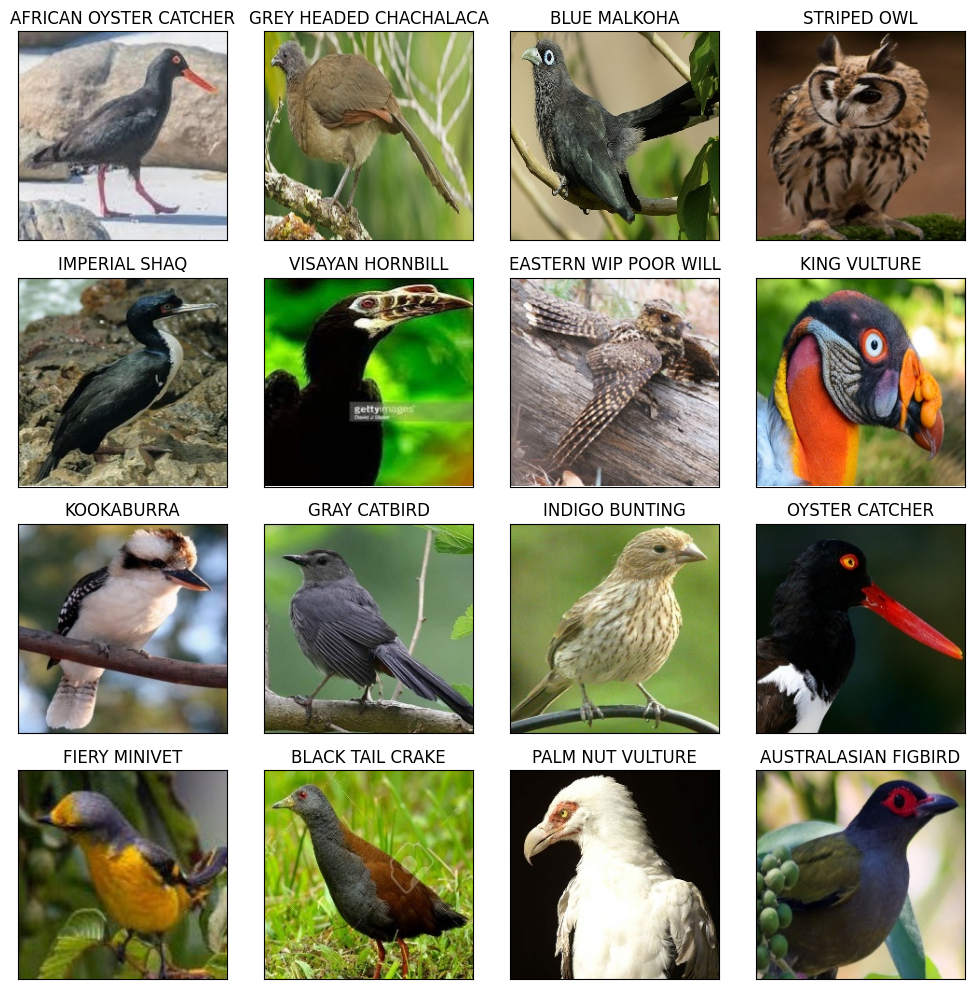

In [41]:
random_index = np.random.randint(0, len(df_train), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(dataset_dir + df_train['filepaths'][random_index[i]]))
    ax.set_title(df_train['labels'][random_index[i]])
plt.tight_layout()
plt.show()

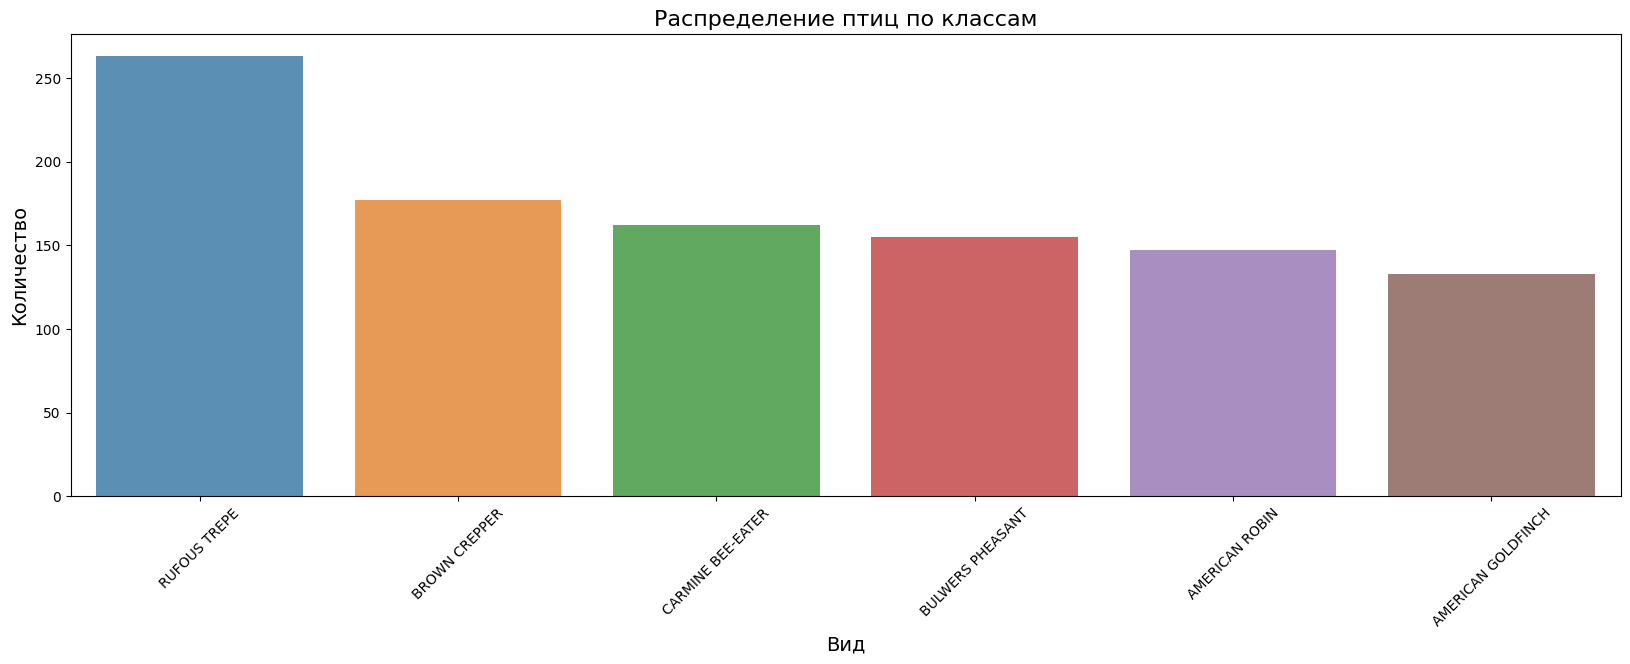

In [42]:
# Проредим список для наглядности
all_label_counts = df_train['labels'].value_counts()
bar_labels = all_label_counts[::100]

plt.figure(figsize=(20, 6))
sns.barplot(x=bar_labels.index, y=bar_labels.values, alpha=0.8)
plt.title('Распределение птиц по классам', fontsize=16)
plt.xlabel('Вид', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [43]:
print(f'Самый многочисленный класс представлен в выборке в {round(all_label_counts.max() / all_label_counts.min(), 2)} раза больше, чем самый малочисленный')

Самый многочисленный класс представлен в выборке в 2.02 раза больше, чем самый малочисленный


Заметим, что в датасете наблюдается серьезная диспропорция классов. На это необходимо будет обратить внимание при выборе модели.

Или же можно решить эту проблему аугментацией изображений для малопредставленных в обучающей выборке классов. Будем исходить из того, что в реальных задачах вероятность получить на вход модели фотографии разных видов птиц будет одинакова для всех классов. 

Построим пайплайн для аугментации:

In [44]:
aug_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Напишем функцию для аугментации данных только для тех классов, количество изображений в которых меньше значения целевого параметра аугментации

In [45]:
def augment_images(class_name, target_count, data_dir, save_dir, datagen):
    if class_name == 'PARAKETT AUKLET':
        if data_dir == train_dir:
            class_dir = os.path.join(train_dir, 'PARAKETT  AUKLET')
        if data_dir == test_dir:
            class_dir = os.path.join(test_dir, 'PARAKETT  AUKLET')
        else:
            class_dir == os.path.join('PARAKETT AUKLET')
    else:
        class_dir = os.path.join(data_dir, class_name)
    images = os.listdir(class_dir)
    current_count = len(images)
    images_needed = target_count - current_count

    if images_needed <= 0:
        return

    print(f"Аугментируем {images_needed} изображений для класса {class_name}")
    
    class_save_dir = os.path.join(save_dir, class_name)
    os.makedirs(class_save_dir, exist_ok=True)

    for i in range(images_needed):
        image_path = os.path.join(class_dir, images[i % current_count])
        img = load_img(image_path)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)

        augmented_iter = datagen.flow(x, batch_size=1)

        save_path = os.path.join(class_save_dir, f"aug_{i}.jpg")
        aug_img = next(augmented_iter)[0].astype(np.uint8)
        aug_img = np.squeeze(aug_img)
        tf.keras.preprocessing.image.save_img(save_path, aug_img)

In [46]:
data_dir = train_dir
class_name = 'ABBOTTS BABBLER'
class_dir = os.path.join(data_dir, class_name)
images = os.listdir(class_dir)
print(class_dir)
len(images)

/kaggle/input/100-bird-species/train/ABBOTTS BABBLER


163

In [47]:
target_count = all_label_counts.max()
data_dir = train_dir
save_dir = '/kaggle/working/train'
datagen = aug_datagen
if not os.path.exists(save_dir):
    for class_name in df_train['labels'].unique():
            augment_images(class_name, target_count, data_dir, save_dir, datagen)

In [48]:
augmented_dir = '/kaggle/working/train'
augmented_data = []

# Пройдемся по всем папкам и файлам в директории аугментированных изображений
for class_name in os.listdir(augmented_dir):
    class_dir = os.path.join(augmented_dir, class_name)
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            augmented_data.append({'filepaths': img_path, 'labels': class_name})

df_aug = pd.DataFrame(augmented_data)
df_aug.head()

,filepaths,labels
0,/kaggle/working/train/ABBOTTS BABBLER/aug_3.jpg,ABBOTTS BABBLER
1,/kaggle/working/train/ABBOTTS BABBLER/aug_74.jpg,ABBOTTS BABBLER
2,/kaggle/working/train/ABBOTTS BABBLER/aug_61.jpg,ABBOTTS BABBLER
3,/kaggle/working/train/ABBOTTS BABBLER/aug_9.jpg,ABBOTTS BABBLER
4,/kaggle/working/train/ABBOTTS BABBLER/aug_57.jpg,ABBOTTS BABBLER


In [49]:
df_aug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  480 non-null    object
 1   labels     480 non-null    object
dtypes: object(2)
memory usage: 7.6+ KB


Посмотрим на фотографии, получившиеся в результате аугментации данных

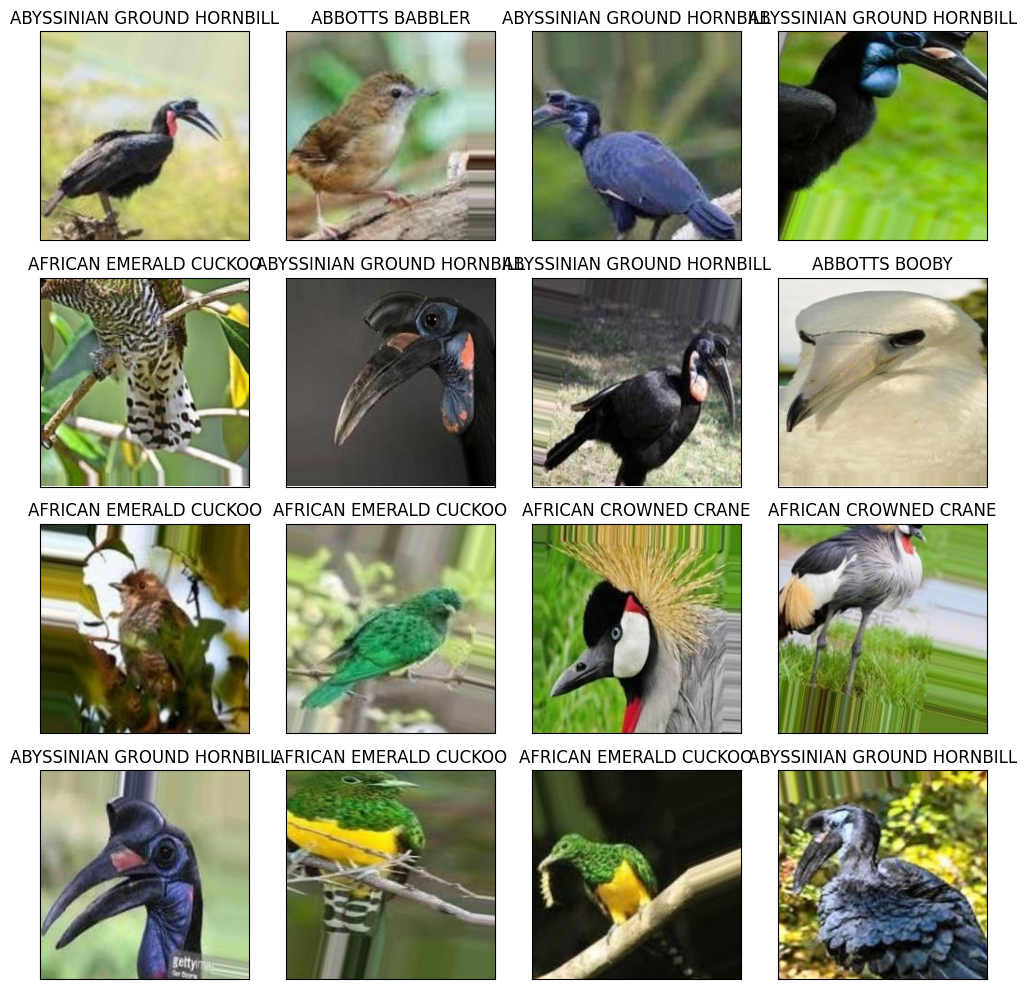

In [50]:
random_index = np.random.randint(0, len(df_aug), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_aug['filepaths'][random_index[i]]))
    ax.set_title(df_aug['labels'][random_index[i]])
plt.tight_layout()
plt.show()

Оставим от датасетов только метки класса и путь к изображению птицы

In [51]:
df_train = df_train[['filepaths', 'labels']]
df_train['filepaths'] = df_train['filepaths'].apply(lambda x: os.path.join(dataset_dir, x))

df_val = df_val[['filepaths', 'labels']]
df_val['filepaths'] = df_val['filepaths'].apply(lambda x: os.path.join(dataset_dir, x))

df_test = df_test[['filepaths', 'labels']]
df_test['filepaths'] = df_test['filepaths'].apply(lambda x: os.path.join(dataset_dir, x))

df_train.head()

,filepaths,labels
0,/kaggle/input/100-bird-species/train/ABBOTTS B...,ABBOTTS BABBLER
1,/kaggle/input/100-bird-species/train/ABBOTTS B...,ABBOTTS BABBLER
2,/kaggle/input/100-bird-species/train/ABBOTTS B...,ABBOTTS BABBLER
3,/kaggle/input/100-bird-species/train/ABBOTTS B...,ABBOTTS BABBLER
4,/kaggle/input/100-bird-species/train/ABBOTTS B...,ABBOTTS BABBLER


In [52]:
df_train_orig = df_train.copy()

In [81]:
df_train = pd.concat([df_train_orig, df_aug], ignore_index=True)
df_train.head()

,filepaths,labels
0,/kaggle/input/100-bird-species/train/ABBOTTS B...,ABBOTTS BABBLER
1,/kaggle/input/100-bird-species/train/ABBOTTS B...,ABBOTTS BABBLER
2,/kaggle/input/100-bird-species/train/ABBOTTS B...,ABBOTTS BABBLER
3,/kaggle/input/100-bird-species/train/ABBOTTS B...,ABBOTTS BABBLER
4,/kaggle/input/100-bird-species/train/ABBOTTS B...,ABBOTTS BABBLER


In [82]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85115 entries, 0 to 85114
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  85115 non-null  object
 1   labels     85115 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [55]:
df_val.head()

,filepaths,labels
0,/kaggle/input/100-bird-species/valid/ABBOTTS B...,ABBOTTS BABBLER
1,/kaggle/input/100-bird-species/valid/ABBOTTS B...,ABBOTTS BABBLER
2,/kaggle/input/100-bird-species/valid/ABBOTTS B...,ABBOTTS BABBLER
3,/kaggle/input/100-bird-species/valid/ABBOTTS B...,ABBOTTS BABBLER
4,/kaggle/input/100-bird-species/valid/ABBOTTS B...,ABBOTTS BABBLER


При помощи аугментации изображений были сбалансированы классы. Теперь каждый класс представляет 263 изображений.

Создадим загрузчики данных для каждого датасета

In [56]:
for col in df_train.columns.tolist():
    print(f'Уникальных значений в столбце {col}: {len(df_train[col].unique())}')
    
for col in df_val.columns.tolist():
    print(f'Уникальных значений в столбце {col}: {len(df_val[col].unique())}')
    
for col in df_test.columns.tolist():
    print(f'Уникальных значений в столбце {col}: {len(df_test[col].unique())}')

Уникальных значений в столбце filepaths: 85115
Уникальных значений в столбце labels: 525
Уникальных значений в столбце filepaths: 2625
Уникальных значений в столбце labels: 525
Уникальных значений в столбце filepaths: 2625
Уникальных значений в столбце labels: 525


Из-за замеченных ошибок в наименовании директорий классов, стоит удостовериться в том, что все файлы датасета доступны

In [ ]:
def check_file_existence(df):
    missing_files = df[~df['filepaths'].apply(lambda x: os.path.exists(x))]
    if not missing_files.empty:
        print(f"Missing files: {len(missing_files)}")
        print(missing_files)
    else:
        print("No missing files.")

print("Checking training data...")
check_file_existence(df_train)

print("Checking validation data...")
check_file_existence(df_val)

print("Checking test data...")
check_file_existence(df_test)


In [59]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

val_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [97]:
batch_size = 32
target_size = (224, 224)

train_images = train_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col='filepaths',
    y_col='labels',
    target_size=target_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

val_images = val_generator.flow_from_dataframe(
    dataframe=df_val,
    x_col='filepaths',
    y_col='labels',
    target_size=target_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

test_images = test_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col='filepaths',
    y_col='labels',
    target_size=target_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size
)

Found 85115 validated image filenames belonging to 525 classes.
Found 2625 validated image filenames belonging to 525 classes.
Found 2625 validated image filenames belonging to 525 classes.


Построим бейзлайн в виде простенькой сверточной нейросети, чтобы проверить данные и получить нижнюю границу оценки метрик. В качестве метрик возьмем точность и F1-score как более объективную.

In [98]:
# Define the input shape based on your image dimensions
input_shape = (224, 224, 3)  # Example for 224x224 RGB images

# Create the model
def create_cnn_baseline(input_shape, num_classes):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(8, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

num_classes = 525

baseline_model = create_cnn_baseline(input_shape, num_classes)

adam_optimizer = Adam(learning_rate=0.01)
baseline_model.compile(optimizer=adam_optimizer, 
                       loss='categorical_crossentropy', 
                       metrics=['accuracy'])

baseline_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 222, 222, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 111, 111, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 98568)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │     3,154,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 525)            │        17,325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,171,757 (12.10 MB)

 Trainable params: 3,171,757 (12.10 MB)

 Non-trainable params: 0 (0.00 B)

Так как это бейзлайн модель, не будем заморачиваться с тонкой настройкой обучения.

In [99]:
log_dir = os.path.join(working_dir, "logs/fit/baseline/") + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_baseline_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

baseline_history = baseline_model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10
)

Epoch 1/10
   5/2660 ━━━━━━━━━━━━━━━━━━━━ 2:03 46ms/step - accuracy: 0.0160 - loss: 2107.9536

W0000 00:00:1716428046.703948     187 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2660/2660 ━━━━━━━━━━━━━━━━━━━━ 150s 55ms/step - accuracy: 0.0029 - loss: 31.8072 - val_accuracy: 0.0027 - val_loss: 6.3480
Epoch 2/10
2660/2660 ━━━━━━━━━━━━━━━━━━━━ 0s 7us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10
2660/2660 ━━━━━━━━━━━━━━━━━━━━ 150s 56ms/step - accuracy: 0.0039 - loss: 6.2630 - val_accuracy: 0.0015 - val_loss: 6.2774
Epoch 4/10
2660/2660 ━━━━━━━━━━━━━━━━━━━━ 0s 5us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10
 130/2660 ━━━━━━━━━━━━━━━━━━━━ 2:13 53ms/step - accuracy: 0.0034 - loss: 6.2542

KeyboardInterrupt: 

In [100]:
enet_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

enet_model.trainable = False

inputs = enet_model.input
x = Dense(128, activation='relu')(enet_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)
outputs = Dense(525, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_8[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,381,488 (16.71 MB)

 Trainable params: 331,917 (1.27 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Настроим колбэки для более тонкой настройки обучения модели:

In [102]:

# Установим сохранение весов модели
checkpoint_path = os.path.join(working_dir, "logs/birds_classification_model_checkpoint.weights.h5")
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

log_dir = os.path.join(working_dir, "logs/fit/") + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Установим колбэк для ранней остановки обучения модели
early_stopping = EarlyStopping(monitor = "val_loss", # Модель будет ориентироваться на val_loss
                               patience = 5,
                               restore_best_weights = True) # Если val_loss снижается 5 эпох подряд, обучение окончится преждевременно

# Будем уменьшать скорость обучения при выходе на плато
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [ ]:
history = model.fit(
    train_images,
    epochs=150,
    validation_data=val_images,
    callbacks=[
        early_stopping,
        tensorboard_callback,
        checkpoint_callback,
        reduce_lr
    ]
)

Epoch 1/150


W0000 00:00:1716429627.834912     186 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1296/2660 ━━━━━━━━━━━━━━━━━━━━ 2:27 108ms/step - accuracy: 0.0028 - loss: 6.4910

W0000 00:00:1716429767.715084     186 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2659/2660 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.0065 - loss: 6.3110

W0000 00:00:1716429891.197375     186 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2660/2660 ━━━━━━━━━━━━━━━━━━━━ 318s 105ms/step - accuracy: 0.0065 - loss: 6.3108 - val_accuracy: 0.1512 - val_loss: 4.8241 - learning_rate: 1.0000e-04
Epoch 2/150
2660/2660 ━━━━━━━━━━━━━━━━━━━━ 161s 60ms/step - accuracy: 0.0688 - loss: 5.0396 - val_accuracy: 0.4560 - val_loss: 3.0093 - learning_rate: 1.0000e-04
Epoch 3/150
2660/2660 ━━━━━━━━━━━━━━━━━━━━ 158s 59ms/step - accuracy: 0.1508 - loss: 4.0742 - val_accuracy: 0.6240 - val_loss: 2.1468 - learning_rate: 1.0000e-04
Epoch 4/150
2660/2660 ━━━━━━━━━━━━━━━━━━━━ 155s 58ms/step - accuracy: 0.2139 - loss: 3.5389 - val_accuracy: 0.7055 - val_loss: 1.6657 - learning_rate: 1.0000e-04
Epoch 5/150
2660/2660 ━━━━━━━━━━━━━━━━━━━━ 159s 60ms/step - accuracy: 0.2698 - loss: 3.1698 - val_accuracy: 0.7516 - val_loss: 1.3929 - learning_rate: 1.0000e-04
Epoch 6/150
2660/2660 ━━━━━━━━━━━━━━━━━━━━ 161s 60ms/step - accuracy: 0.3107 - loss: 2.8935 - val_accuracy: 0.7787 - val_loss: 1.2029 - learning_rate: 1.0000e-04
Epoch 7/150
2660/2660 ━━━━━━━━━━━━━━━━━

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()